In [9]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
BASE_URL = "http://quotes.toscrape.com/"
START_PAGE = "/page/1/"

def scrape_quotes():
    quotes_data = []         # List to store scraped quote data as dictionaries
    next_page = START_PAGE   # Start with the first page
    visited_pages = set()    # Track visited pages to avoid infinite loops

    while next_page:
        # Check for potential infinite loops (repeated page)
        if next_page in visited_pages:
            print(f"Detected a loop at {next_page}, exiting...")
            break
        visited_pages.add(next_page)

        url = BASE_URL + next_page     # Construct the full URL for this page
        print(f"Scraping {url}")       # Log progress

        try:
            # Request the web page with a 5-second timeout
            response = requests.get(url, timeout=5)
            response.raise_for_status()  # Raise error for bad responses (404, 500, etc.)
        except requests.RequestException as e:
            print(f"Request failed: {e}")  # Handle request errors gracefully
            break

        # Parse page HTML
        soup = BeautifulSoup(response.text, "html.parser")
        quotes = soup.find_all("div", class_="quote")   # Find all quote blocks

        if not quotes:
            print(f"No quotes found on {url}, exiting...")  # Stop if there are no quotes
            break

        # Extract data from each quote block
        for quote in quotes:
            try:
                text = quote.find("span", class_="text").get_text(strip=True)      # Get quote text
                author = quote.find("small", class_="author").get_text(strip=True) # Get author
                tags = [tag.get_text(strip=True) for tag in quote.find_all("a", class_="tag")]  # Tags as list
                # Store in a dictionary and append to results list
                quotes_data.append({
                    "Quote": text,
                    "Author": author,
                    "Tags": ", ".join(tags)
                })
            except AttributeError as e:
                # Handle missing fields in quote block gracefully
                print(f"Error parsing quote block: {e}")
                continue

        # Find link to next page and update loop variable
        next_btn = soup.find("li", class_="next")
        next_page = next_btn.find("a")["href"] if next_btn else None

    return quotes_data      # Return all collected quotes

# scrape_quotes()

In [11]:
def save_to_csv(data, filename="quotes.csv"):
    # Check if the data list is empty; print message and exit if so
    if not data:
        print("No data to save.")
        return

    try:
        # Open the target file in write mode, ensuring correct encoding for text
        with open(filename, "w", newline='', encoding='utf-8') as f:
            # Create a CSV writer that writes dictionaries with specified fields
            writer = csv.DictWriter(f, fieldnames=["Quote", "Author", "Tags"])
            writer.writeheader()        # Write the column headers as the first row
            writer.writerows(data)      # Write each quote dictionary as a row
        print(f"Saved {len(data)} quotes to {filename}")  # Success message
    except Exception as e:
        # Print error message in case writing fails
        print(f"Failed to save file: {e}")

In [12]:
# Main execution block: scrape data and save it
if __name__ == "__main__":
    scraped_data = scrape_quotes()      # Call scraping function to get data
    save_to_csv(scraped_data)           # Save scraped data into CSV file

Scraping http://quotes.toscrape.com//page/1/
Scraping http://quotes.toscrape.com//page/2/
Scraping http://quotes.toscrape.com//page/3/
Scraping http://quotes.toscrape.com//page/4/
Scraping http://quotes.toscrape.com//page/5/
Scraping http://quotes.toscrape.com//page/6/
Scraping http://quotes.toscrape.com//page/7/
Scraping http://quotes.toscrape.com//page/8/
Scraping http://quotes.toscrape.com//page/9/
Scraping http://quotes.toscrape.com//page/10/
Saved 100 quotes to quotes.csv


In [13]:
file_path = '/content/quotes.csv'
data = pd.read_csv(file_path)
data.head()

,Quote,Author,Tags
0,“The world as we have created it is a process ...,Albert Einstein,"change, deep-thoughts, thinking, world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"abilities, choices"
2,“There are only two ways to live your life. On...,Albert Einstein,"inspirational, life, live, miracle, miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"aliteracy, books, classic, humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"be-yourself, inspirational"


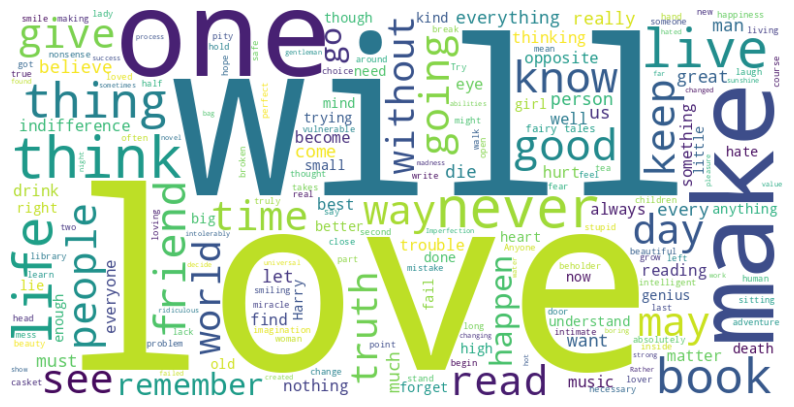

In [14]:
all_quotes = " ".join(data['Quote'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_quotes)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

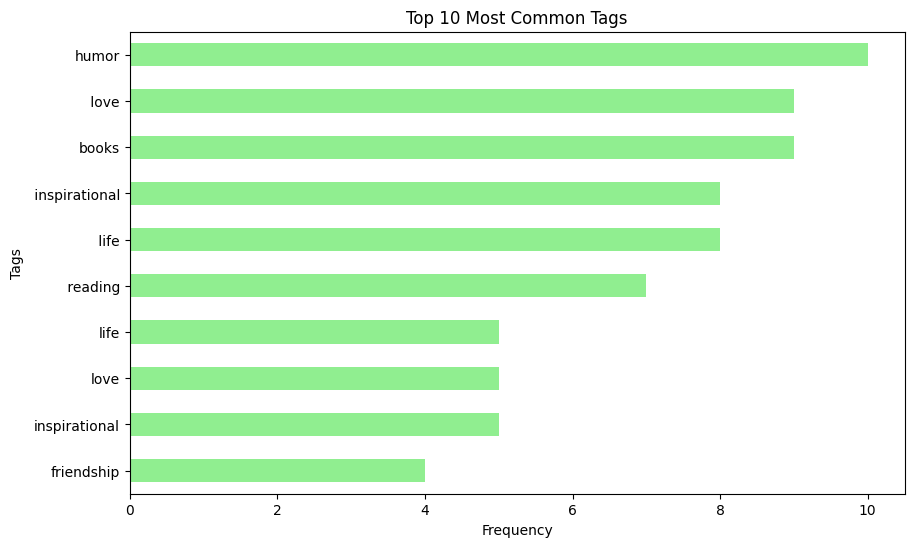

In [15]:
tag_counts = data['Tags'].str.split(',').explode().value_counts()

plt.figure(figsize=(10, 6))
tag_counts.head(10).plot(kind='barh', color='lightgreen')
plt.title("Top 10 Most Common Tags")
plt.xlabel("Frequency")
plt.ylabel("Tags")
plt.gca().invert_yaxis()
plt.show()

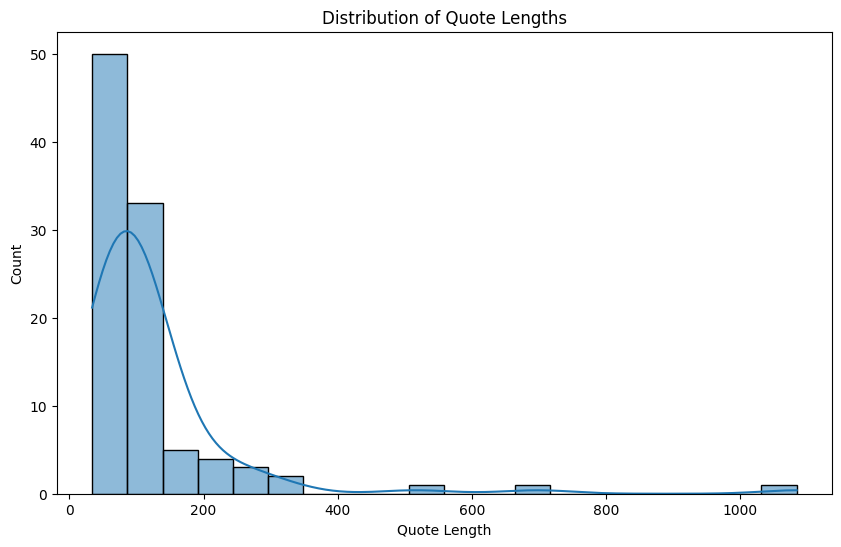

In [16]:
data['Quote Length'] = data['Quote'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['Quote Length'], bins=20, kde=True)
plt.title('Distribution of Quote Lengths')
plt.show()